<a href="https://colab.research.google.com/github/namrathakilari/IIITH-Labs-and-Projects/blob/main/Module%204/STP_Module_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [12]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):

                z=np.dot(self.w,X[i]+self.b)
                if y[i]*z<=0:
                  self.w+=self.lr*y[i]*X[i]
                  self.b+=self.lr*y[i]
                  count+=1

            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred=model_p.predict(X_test)
print("predictions:",y_pred[:10])
print("mistakes:",model_p.mistakes)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

predictions: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
mistakes: [1422, 1375, 1404, 1135, 1072, 1083, 1096, 1385, 1373, 1516, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586, 1586]
Accuracy: 0.6280487804878049


The perceptron is predicting -1 for all the test samples, which means it is giving same output for every input. This shows that the model could not able to find a proper seperation plane between the features and classes.

Also we can observe that after some epochs the errors become constant and not reducing anymore. This means the perceptron stop learning after a point.

# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [13]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
           z=np.dot(X,self.w)+self.b

           dw=(1/n)*np.dot(X.T,(y-z))
           db=(1/n)*np.sum(y-z)

           self.w-=self.lr*dw
           self.b-=self.lr*db
           cost = (1/(2*n)) * np.sum((z - y)**2)
           self.cost_history.append(cost)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_gd = GDWaterClassifier(lr=0.001, epochs=500)
model_gd.fit(X_train, y_train)

y_pred = model_gd.predict(X_test)
print("predictions:",y_pred[:10])

from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))

print("Final cost:", model_gd.cost_history[-1])

predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Accuracy: 0.3719512195121951
Final cost: 0.5409610288261478


# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [14]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                 condition = y[i] * (np.dot(self.w, x_i) + self.b) >= 1

                 if condition:

                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                 else:

                    self.w -= self.lr * (2 * self.lambda_param * self.w - y[i] * x_i)
                    self.b -= self.lr * (-y[i])


    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_margin = MarginWaterClassifier(lr=0.001, lambda_param=0.01, epochs=500)
model_margin.fit(X_train, y_train)

y_pred = model_margin.predict(X_test)
print("predictions:",y_pred[:10])


from sklearn.metrics import accuracy_score
print("Accuracy:", accuracy_score(y_test, y_pred))


predictions: [-1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
Accuracy: 0.6280487804878049


# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

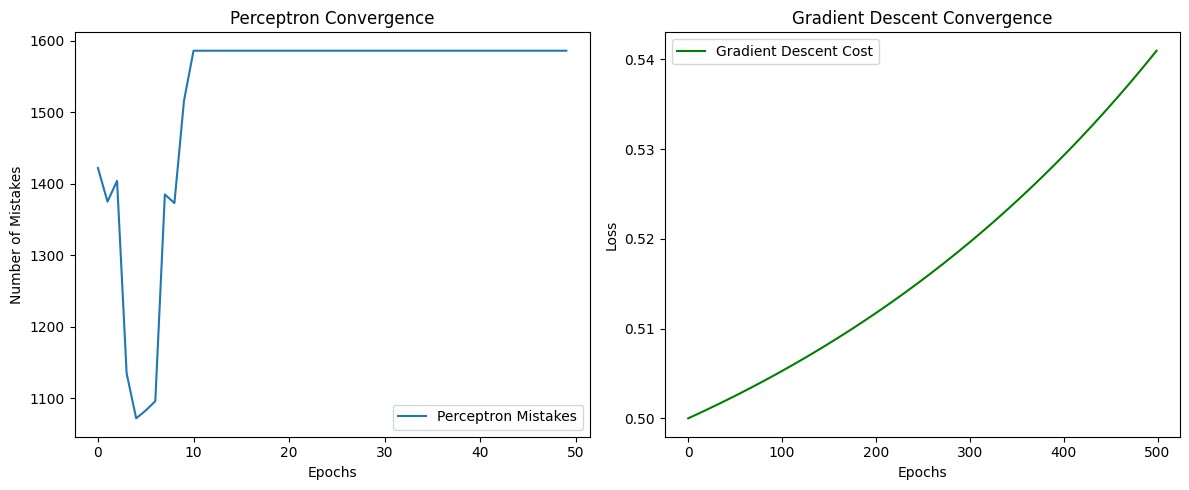

In [16]:
# Train models
model_p = WaterPerceptron(lr=0.01, epochs=50)
model_p.fit(X_train, y_train)

model_gd = GDWaterClassifier(lr=0.001, epochs=500)
model_gd.fit(X_train, y_train)

# Plot convergence
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(model_p.mistakes, label="Perceptron Mistakes")
plt.xlabel("Epochs")
plt.ylabel("Number of Mistakes")
plt.title("Perceptron Convergence")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_gd.cost_history, label="Gradient Descent Cost", color="green")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Gradient Descent Convergence")
plt.legend()

plt.tight_layout()
plt.show()


Gradient Descent minimizes the overall loss across all samples, while Perceptron updates only on mistakes, causing fluctuations.

In [17]:
from sklearn.metrics import accuracy_score

# Train Margin-based model
model_margin = MarginWaterClassifier(lr=0.001, lambda_param=0.01, epochs=500)
model_margin.fit(X_train, y_train)

# Predictions
y_pred_p = model_p.predict(X_test)
y_pred_gd = model_gd.predict(X_test)
y_pred_margin = model_margin.predict(X_test)

# Accuracy
acc_p = accuracy_score(y_test, y_pred_p)
acc_gd = accuracy_score(y_test, y_pred_gd)
acc_margin = accuracy_score(y_test, y_pred_margin)

print("Test Accuracy:")
print(f"Perceptron: {acc_p:.4f}")
print(f"Gradient Descent: {acc_gd:.4f}")
print(f"Margin Classifier: {acc_margin:.4f}")


Test Accuracy:
Perceptron: 0.6280
Gradient Descent: 0.3720
Margin Classifier: 0.6280


In [18]:
# Distance from decision boundary (|w·x + b|)
def margin_distance(model, X):
    return np.abs(np.dot(X, model.w) + model.b)

# Compare margin confidence on test data
perceptron_margin = margin_distance(model_p, X_test)
margin_model_margin = margin_distance(model_margin, X_test)

print("Average confidence near boundary:")
print("Perceptron:", np.mean(perceptron_margin))
print("Margin Classifier:", np.mean(margin_model_margin))


Average confidence near boundary:
Perceptron: 668.5680374901517
Margin Classifier: 0.9842248829576116


The Margin-based classifier maintains a larger, more reliable distance from the decision boundary, making it safer and more trustworthy for water quality decisions.

# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*


Q1. If the learning rate is too high, the model takes very large steps while learning. Instead of slowly moving toward the best solution, it can jump past it again and again. This causes the loss to go up and down or even increase, meaning the model does not learn properly and may completely fail to converge.

Q2. Using −1 and 1 makes the math easier and cleaner for linear classifiers. It allows us to easily check whether a prediction is correct and how confident the model is using one simple formula.

Q3. The margin-based classifier works best with noisy data. Unlike the Perceptron, it does not try to perfectly classify every point. Instead, it focuses on keeping a safe distance between potable and non-potable samples. This makes it more stable, less affected by noisy or outlier data, and better at generalizing to new samples.